In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn
import os

In [3]:
def compute_distance(gps_coordinate1, gps_coordinate2):
    ## gps_coordinate1 = [latitude, longitude]
    R = 6371e3;
    latitude1 = math.radians(gps_coordinate1[0])
    latitude2 = math.radians(gps_coordinate2[0])
    longitude1= gps_coordinate1[1]
    longitude2= gps_coordinate2[1]
    
    lat_diff = latitude2 - latitude1
    long_diff= math.radians(longitude2- longitude1)
    
    a = math.pow(math.sin(lat_diff/2), 2) + \
        math.cos(latitude1) * math.cos(latitude2) * \
        math.pow(math.sin(long_diff/2), 2)
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    
    return distance


S2-Run3P.csv


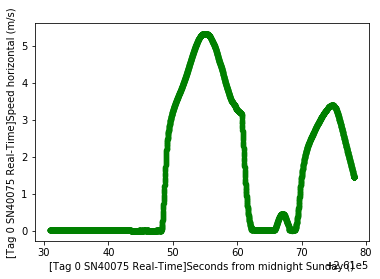

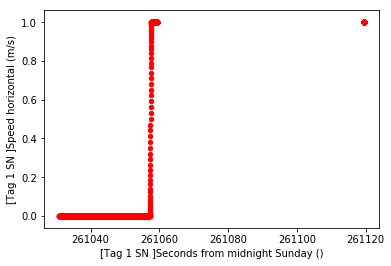

IndexError: list index out of range

In [36]:
scenario_path = "./AAA_DATA/January_Data/Scenario_S2"
# F5 : Target0=ego , Target3 = pedestrian

list_of_files = [file for file in os.listdir(scenario_path) if file.endswith('.csv')]
ego_time = '[Tag 0 SN40075 Real-Time]Seconds from midnight Sunday ()'
ego_long = '[Tag 0 SN40075 Real-Time]Longitude (deg)'
ego_lat  = '[Tag 0 SN40075 Real-Time]Latitude (deg)'
ego_accel = '[Tag 0 SN40075 Real-Time]Acceleration forward (m/s²)'
ego_speed = '[Tag 0 SN40075 Real-Time]Speed horizontal (m/s)'

ped_time = '[Tag 1 SN ]Seconds from midnight Sunday ()'
ped_long = '[Tag 1 SN ]Longitude (deg)'
ped_lat  = '[Tag 1 SN ]Latitude (deg)'
ped_accel= '[Tag 1 SN ]Acceleration forward (m/s²)'
ped_speed= '[Tag 1 SN ]Speed horizontal (m/s)'

for file in sorted(list_of_files):
    print(file)
    path_to_file = os.path.join(scenario_path, file)
    table = pd.read_csv(path_to_file, sep=',')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)  
    
    table.plot(kind='scatter',x=ego_time, y=ego_speed,color='green')
    plt.show()
    table.plot(kind='scatter',x=ped_time, y=ped_speed ,color='red')
    plt.show()

    # Parse Scenic Parameters
    pos_stopped = []
    pos_moving = []
    stopped = True
    moving  = False
    hesitate = False
    recorded = False
    ped_trigger_time = -1
    hesitate_start_time = -1
    hesitate_stop_time = -1
    ped_start_pos = [table.iloc[0][ped_lat], table.iloc[0][ped_long]]
    ped_stop_pos  = []
    ego_time_start = -10000
    ped_deceleration_count = 0
    started = False
    pedestrian_completion_index = -1
    hesitation_completed = False
    first_time_moving = False
    ped_comes_to_halt_index = []

    for index, row in table.iterrows():
        accel = table[ped_accel][index]
        speed = table[ped_speed][index]

        if table[ego_accel][index] > 0.1 and table[ego_speed][index] > 0.05 and not started:
            ego_time_start = table[ego_time][index]
            started = True

        if speed >= 0 and accel > 0.1:
            pos_moving.append(index)

            if stopped:
                stopped = False
                moving  = True

                if not recorded:
                    ped_trigger_index = index
                    recorded = True

                if hesitate and not first_time_moving:
                    hesitate_stop_time = row[ped_time]
                    hesitation_completed = True
                    first_time_moving = True

        if  speed <= 0 and accel < 0:
            pos_stopped.append(index)

            if moving:
                stopped = True
                moving  = False
                hesitate = True
                ped_comes_to_halt_index.append(index)
    #             ped_hesitation_start_index = index

        if hesitation_completed and accel < 0:
            pedestrian_completion_index = index


    # Pedestrian stops to hesitate at:
    hesitation_start_index = ped_comes_to_halt_index[0]
    hesitate_start_time = table[ped_time][hesitation_start_index]
    ped_stop_pos = [table[ped_lat][hesitation_start_index], table[ped_long][hesitation_start_index]]

    # ped_trigger_pos_x  = pedestrian_table['Latitude (deg)'][pedestrian_completion_index]
    # ped_trigger_pos_y  = pedestrian_table['Longitude (deg)'][pedestrian_completion_index]
#     pedestrian_completion_time = table[ped_time][pedestrian_completion_index]
    pedestrian_trigger_time = table[ped_time][ped_trigger_index]

    ego_trigger_index = -1
    for index, row in table.iterrows():   
        if table[ego_time][index]==pedestrian_trigger_time:
            ego_trigger_index = index
            print("found a match!")

    ego_trigger_pos_x  = table[ego_lat][ego_trigger_index]
    ego_trigger_pos_y  = table[ego_long][ego_trigger_index]


    ## Computing Scenic Parameters
    hesitate_time  = hesitate_stop_time - hesitate_start_time
    ped_walkDistance = compute_distance(ped_start_pos, ped_stop_pos)
    startDelay = pedestrian_trigger_time - ego_time_start
    
    print("SCENARIO "+file)
    print("hesitate_time: ", hesitate_time)
    print("pedestrian walk distance: ", ped_walkDistance)
    print("startDelay : ", startDelay)

    ax = table.plot(kind='scatter',x=ego_time,y=ego_speed,color='green')
    table.plot(kind='scatter',x=ped_time ,y=ped_speed, marker='x', ax = ax ,color='red')
    # ax.set_ylim(-3, 3)
    # ax.set_xlim(259485, 259490)
    plt.axvline(pedestrian_trigger_time)
    plt.axvline(hesitate_start_time)
    plt.axvline(hesitate_stop_time)
    plt.axvline(ego_time_start)
#     plt.axvline(pedestrian_completion_time)
    plt.show()

    # print("Plot of Ego AV below: ")
    # ax = ego_table.plot(kind='scatter',x='Seconds from midnight Sunday ()',y='Speed horizontal (m/s)',color='green')
    # ego_table.plot(kind='scatter',x='Seconds from midnight Sunday ()',y='Acceleration forward (m/s²)', marker='x', ax = ax ,color='red')
    # plt.show()



# print(ego_time_start)
print(hesitate_stop_time)